# DON Concentration Prediction

In this notebook, a robust regression model is developed to predict the DON concentration from the hyperspectral data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import keras
from tensorflow.keras import layers
import xgboost as xgb
import lime
import lime.lime_tabular
import optuna

## 1. Data Exploration and Preprocessing

### - Loading & Inspection

In [2]:
# Load the dataset
df = pd.read_csv('data/MLE-Assignment.csv')

In [ ]:
# Inspect Data
print("Dataset Shape:", df.shape)

print("\nDataset Info:\n")
df.info()

print("\nMissing Values:\n", df.isnull().sum())


Dataset Shape: (500, 450)

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 450 entries, hsi_id to vomitoxin_ppb
dtypes: float64(449), object(1)
memory usage: 1.7+ MB

Missing Values:
 hsi_id           0
0                0
1                0
2                0
3                0
                ..
444              0
445              0
446              0
447              0
vomitoxin_ppb    0
Length: 450, dtype: int64


In [10]:
# Check for outliers using the IQR method on numeric columns
numeric_cols = df.select_dtypes(include=["number"]).columns

Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as values outside 1.5 * IQR
outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).sum()
print("Outliers in each column:\n", outliers)

Outliers in each column:
 0                 0
1                 0
2                 0
3                 0
4                 0
                 ..
444              11
445              11
446              10
447              13
vomitoxin_ppb    80
Length: 449, dtype: int64


In [12]:
# Summary Statistics
print("\nSummary Statistics:\n")
df.describe()


Summary Statistics:



,0,1,2,3,4,5,6,7,8,9,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.443118,0.440761,0.433814,0.426122,0.418990,0.412432,0.405868,0.399815,0.394038,0.389664,...,0.741255,0.740818,0.740459,0.739758,0.739850,0.738738,0.738298,0.737599,0.738099,3410.006000
std,0.044719,0.045520,0.045764,0.046070,0.045405,0.044727,0.044528,0.043773,0.043659,0.043442,...,0.053479,0.053695,0.053812,0.053666,0.053487,0.053601,0.054014,0.054136,0.054297,13095.803483
min,0.311182,0.295321,0.284064,0.282054,0.296702,0.286860,0.262876,0.278523,0.255529,0.261459,...,0.562662,0.585011,0.558412,0.571735,0.575259,0.571767,0.577803,0.576985,0.562302,0.000000
25%,0.410456,0.404310,0.397038,0.389029,0.382102,0.377157,0.369620,0.364823,0.360634,0.355246,...,0.702105,0.703701,0.702988,0.700889,0.701690,0.700638,0.698655,0.698107,0.699673,137.500000
50%,0.449105,0.442651,0.434215,0.425074,0.417075,0.411872,0.405443,0.397917,0.393803,0.387211,...,0.743857,0.745922,0.745062,0.743991,0.744004,0.743965,0.743301,0.745216,0.745733,500.000000
75%,0.480245,0.478822,0.473158,0.464947,0.459232,0.452198,0.444384,0.438728,0.431165,0.427039,...,0.777884,0.776210,0.777069,0.774759,0.775698,0.775686,0.775621,0.774635,0.774310,1700.000000
max,0.556287,0.530168,0.528774,0.533202,0.511909,0.501786,0.504054,0.490692,0.489272,0.472080,...,0.940642,0.940361,0.939153,0.930366,0.942615,0.945225,0.932812,0.931381,0.957860,131000.000000


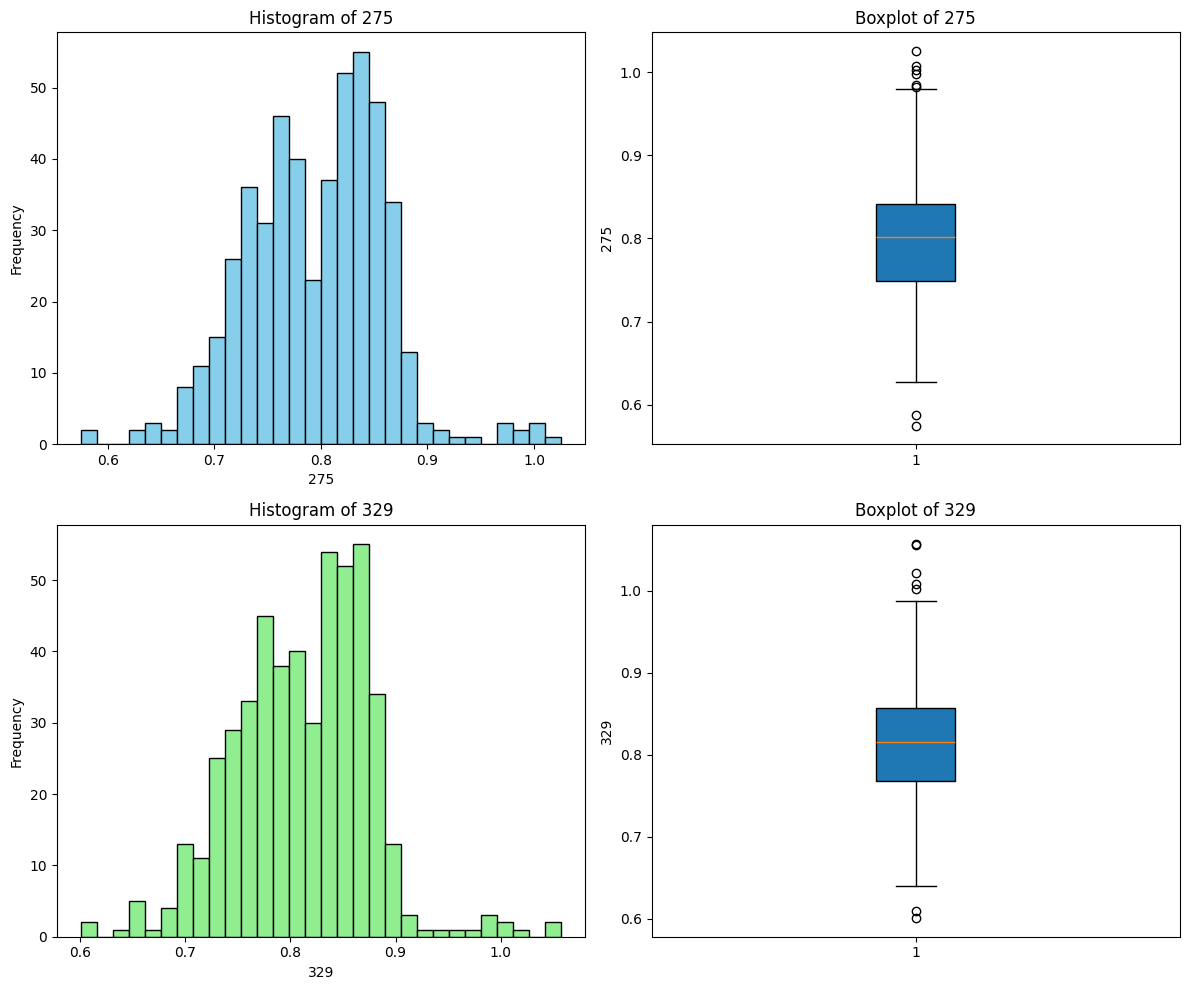

In [ ]:
# Selecting two columns for visualization
columns = ["275", "329"]

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot for the first column
axes[0, 0].hist(df[columns[0]], bins=30, color="skyblue", edgecolor="black")
axes[0, 0].set_title(f"Histogram of {columns[0]}")
axes[0, 0].set_xlabel(columns[0])
axes[0, 0].set_ylabel("Frequency")

axes[0, 1].boxplot(df[columns[0]], vert=True, patch_artist=True)
axes[0, 1].set_title(f"Boxplot of {columns[0]}")
axes[0, 1].set_ylabel(columns[0])

# Plot for the second column
axes[1, 0].hist(df[columns[1]], bins=30, color="lightgreen", edgecolor="black")
axes[1, 0].set_title(f"Histogram of {columns[1]}")
axes[1, 0].set_xlabel(columns[1])
axes[1, 0].set_ylabel("Frequency")

axes[1, 1].boxplot(df[columns[1]], vert=True, patch_artist=True)
axes[1, 1].set_title(f"Boxplot of {columns[1]}")
axes[1, 1].set_ylabel(columns[1])

# Show the plots
plt.tight_layout()
plt.show()

# Interactive plot using plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Selecting two columns for visualization
columns = ["275", "329"]

# Create subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=(f"Histogram of {columns[0]}", f"Boxplot of {columns[0]}", f"Histogram of {columns[1]}", f"Boxplot of {columns[1]}"))

# Plot for the first column
fig.add_trace(go.Histogram(x=df[columns[0]], nbinsx=30, marker_color="skyblue"), row=1, col=1)
fig.add_trace(go.Box(y=df[columns[0]], boxpoints='all', jitter=0.3, pointpos=-1.8, marker_color="skyblue"), row=1, col=2)

# Plot for the second column
fig.add_trace(go.Histogram(x=df[columns[1]], nbinsx=30, marker_color="lightgreen"), row=2, col=1)
fig.add_trace(go.Box(y=df[columns[1]], boxpoints='all', jitter=0.3, pointpos=-1.8, marker_color="lightgreen"), row=2, col=2)

# Update layout
fig.update_layout(height=800, width=1000, title_text="Histograms and Boxplots", showlegend=False)

# Save the plot as an HTML file
fig.write_html("visualizations-interactive/features_visualization.html")

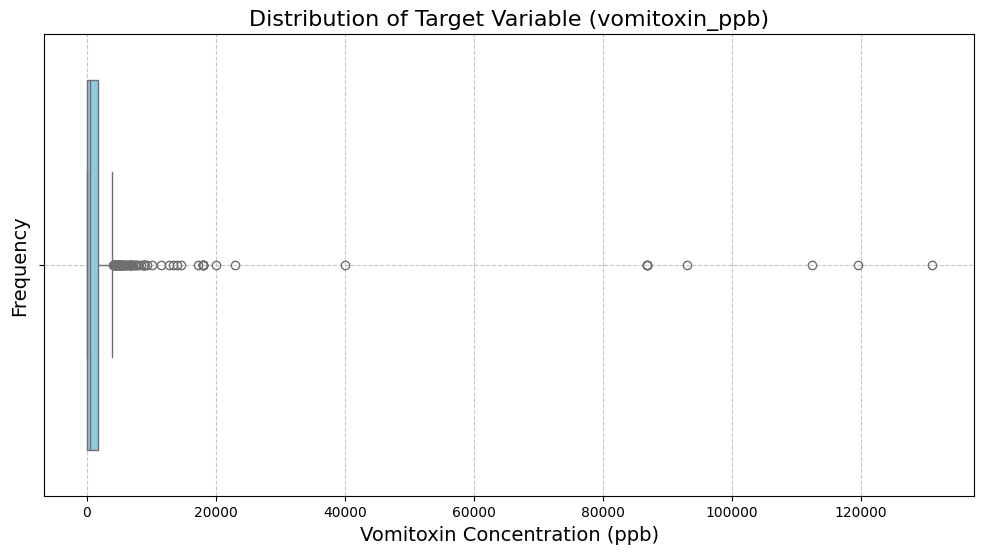

In [ ]:
# The distribution of the target variable with boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['vomitoxin_ppb'], color='skyblue')
plt.title('Distribution of Target Variable (vomitoxin_ppb)', fontsize=16)
plt.xlabel('Vomitoxin Concentration (ppb)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Interactive plot using plotly
fig = go.Figure()
fig.add_trace(go.Box(y=df['vomitoxin_ppb'], boxpoints='all', jitter=0.3, pointpos=-1.8, marker_color="skyblue"))
fig.update_layout(height=1000, width=1000, title_text="Boxplot of Target Variable")
fig.write_html("visualizations-interactive/target_variable_boxplot.html")

### - Preprocessing

In [31]:
# Summary Statistics of the target variable
print("\nSummary Statistics of the Target Variable (vomitoxin_ppb):")
df['vomitoxin_ppb'].describe()


Summary Statistics of the Target Variable (vomitoxin_ppb):


count       500.000000
mean       3410.006000
std       13095.803483
min           0.000000
25%         137.500000
50%         500.000000
75%        1700.000000
max      131000.000000
Name: vomitoxin_ppb, dtype: float64

I am choosing to keep the outliers because:

1. Preserves Real-World Variability – Outliers may carry valuable insights rather than being mere noise, especially in this domain like food tech.
2. Prevents Information Loss – Removing outliers arbitrarily can distort the model’s understanding of extreme but valid cases, leading to biased predictions.


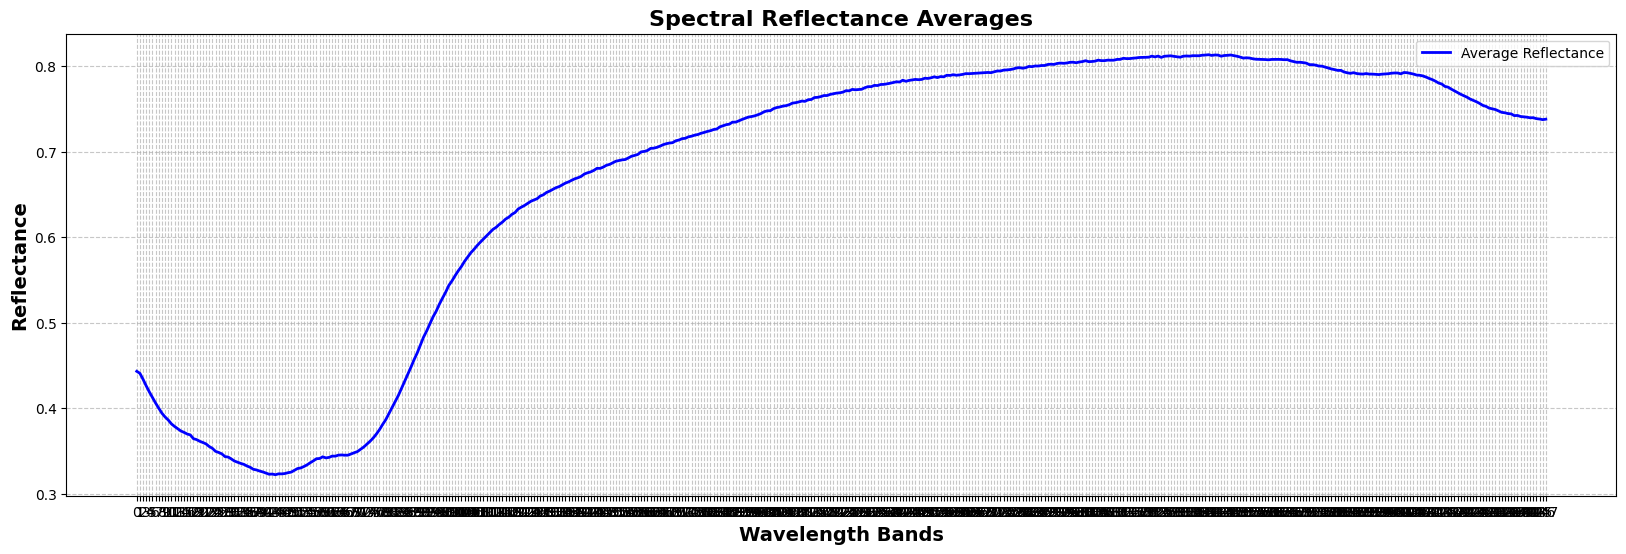

In [ ]:
data = df.copy()
data = data.drop(columns=['hsi_id', 'vomitoxin_ppb'], axis=1)

# Line plot for average reflectance over wavelengths
plt.figure(figsize=(20, 6))
plt.plot(data.mean(), label='Average Reflectance', color='blue', linewidth=2)
plt.xlabel("Wavelength Bands", fontsize=14, fontweight='bold')
plt.ylabel("Reflectance", fontsize=14, fontweight='bold')
plt.title("Spectral Reflectance Averages", fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Interactive plot using plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.columns, y=data.mean(), mode='lines+markers', line=dict(color='blue', width=2)))
fig.update_layout(height=600, width=1000, title_text="Spectral Reflectance Averages", xaxis_title="Wavelength Bands", yaxis_title="Reflectance", showlegend=False)
fig.write_html("visualizations-interactive/spectral_reflectance_averages.html")

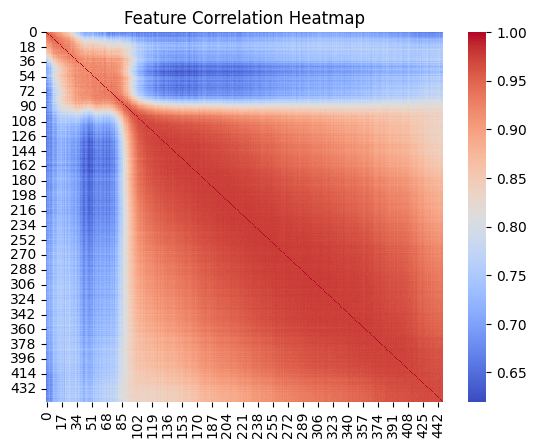

In [ ]:
# Correlation Heatmap for the features
sns.heatmap(data.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

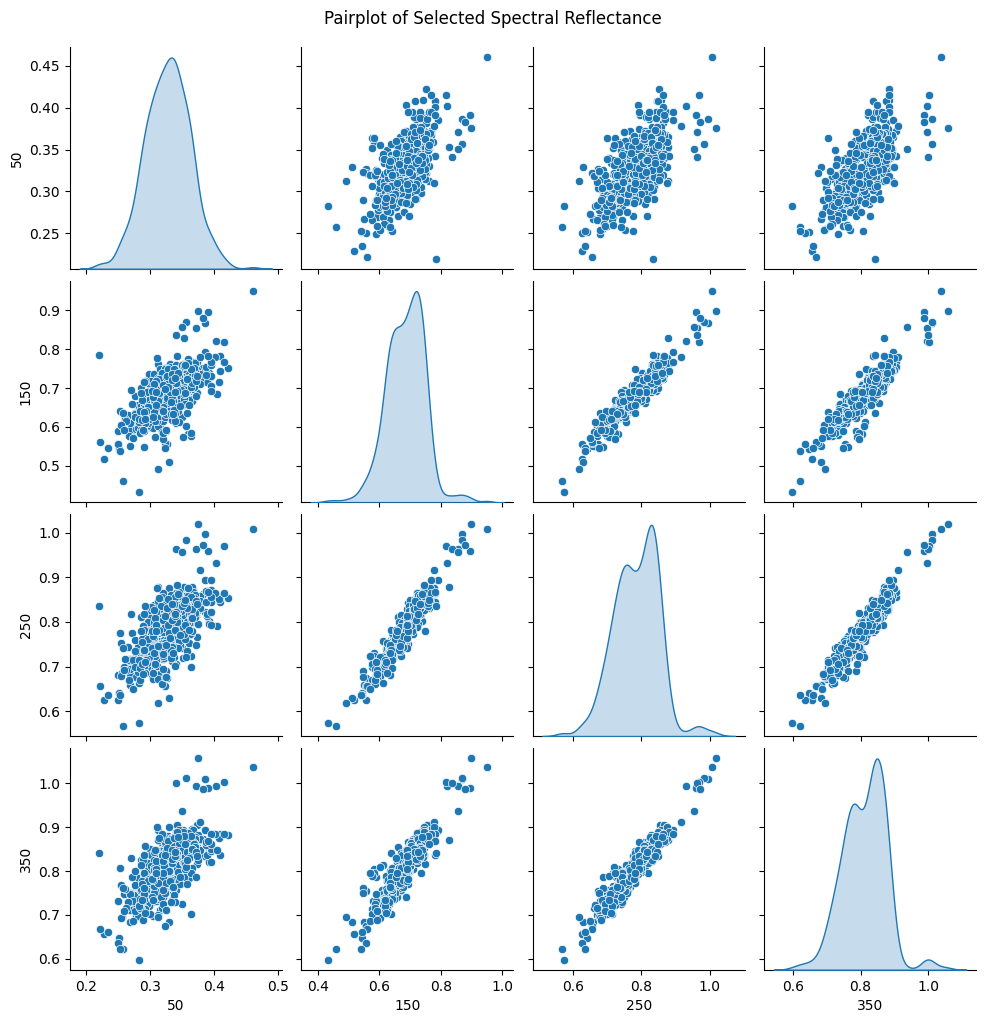

In [ ]:
# Pairplot for sample comparisons
# Select a subset of wavelengths for visualization
selected_cols = ["50", "150", "250", "350"]

# Create the pairplot
sns.pairplot(data[selected_cols], diag_kind='kde', height=2.5)
plt.suptitle("Pairplot of Selected Spectral Reflectance", y=1.02)
plt.show()

# Interactive pairplot using plotly
import plotly.express as px
selected_cols = ["50", "150", "250", "350"]
selected_cols = [str(col) for col in selected_cols]
fig = px.scatter_matrix(data, dimensions=selected_cols, title="Pairplot of Selected Spectral Reflectance")
fig.write_html("visualizations-interactive/pairplot_spectral_reflectance.html")

In [3]:
# Drop the 'hsi_id' column as it is not needed for training
df.drop(columns=['hsi_id'], inplace=True)

# Splitting Features & Target
X = df.iloc[:, :-1].values  # Features
y = df.iloc[:, -1].values   # Target (DON Concentration)

# Normalize Features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split (Data Splitting)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## 2. Model Training

I have selected the following two regression models here -

1. Baseline Model - Feedforward Neural Network (FNN) [Tensforflow/Keras based]
2. Advanced Model - XGBoostRegressor

### Baseline Model - Feedforward Neural Network (FNN) [Tensforflow/Keras based]

In [40]:
# Define the Feedforward Neural Network Model
def fnn_model(trial):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_scaled.shape[1],)))
    for i in range(trial.suggest_int("n_layers", 2, 3)):
        model.add(layers.Dense(trial.suggest_int(f"n_units_{i}", 32, 128, step=32), activation='relu'))
    model.add(layers.Dense(1))  # Output layer for regression
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)), loss='mse', metrics=['mae'])
    return model

In [41]:
# K-Fold Cross Validation & Hyperparameter Optimization
def objective_fnn(trial):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_scores = []
    
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val = X_train[train_index], X_train[val_index]
        y_train_fold, y_val = y_train[train_index], y_train[val_index]
        
        model = fnn_model(trial)
        early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(X_train_fold, y_train_fold, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)
        
        y_pred = model.predict(X_val)
        mae_scores.append(mean_absolute_error(y_val, y_pred))
    
    return np.mean(mae_scores)

In [44]:
study_fnn = optuna.create_study(direction='minimize')
study_fnn.optimize(objective_fnn, n_trials=15)

[I 2025-03-16 21:02:40,911] A new study created in memory with name: no-name-a41bd95e-8179-45f8-9705-69bda0c3b2cf
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000016652DB1BC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


[I 2025-03-16 21:04:49,638] Trial 0 finished with value: 2709.1660596466068 and parameters: {'n_layers': 3, 'n_units_0': 32, 'n_units_1': 32, 'n_units_2': 64, 'learning_rate': 0.002069374631615504}. Best is trial 0 with value: 2709.1660596466068.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-03-16 21:07:05,224] Trial 1 finished with value: 3555.4438106536863 and parameters: {'n_layers': 2, 'n_units_0': 32, 'n_units_1': 32, 'learning_rate': 0.0015952226627865644}. Best is trial 0 with value: 2709.1660596466068.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-03-16 21:08:43,809] Trial 2 finished with value: 2630.801517829895 and parameters: {'n_layers': 3, 'n_units_0': 64, 'n_units_1': 96, 'n_units_2': 128, 'learning_rate': 0.002824556993458847}. Best is trial 2 with value: 2630.801517829895.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


[I 2025-03-16 21:10:23,991] Trial 3 finished with value: 2670.467204818726 and parameters: {'n_layers': 3, 'n_units_0': 96, 'n_units_1': 128, 'n_units_2': 128, 'learning_rate': 0.0018660777509083017}. Best is trial 2 with value: 2630.801517829895.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


[I 2025-03-16 21:11:42,574] Trial 4 finished with value: 2719.3090030288695 and parameters: {'n_layers': 3, 'n_units_0': 96, 'n_units_1': 32, 'n_units_2': 128, 'learning_rate': 0.005795267424586548}. Best is trial 2 with value: 2630.801517829895.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


[I 2025-03-16 21:14:02,253] Trial 5 finished with value: 3508.6391123163703 and parameters: {'n_layers': 3, 'n_units_0': 64, 'n_units_1': 32, 'n_units_2': 32, 'learning_rate': 0.0007774222344257526}. Best is trial 2 with value: 2630.801517829895.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


[I 2025-03-16 21:15:59,953] Trial 6 finished with value: 2720.094510478973 and parameters: {'n_layers': 3, 'n_units_0': 64, 'n_units_1': 32, 'n_units_2': 128, 'learning_rate': 0.0020228369967233563}. Best is trial 2 with value: 2630.801517829895.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-03-16 21:17:57,785] Trial 7 finished with value: 2788.512307929993 and parameters: {'n_layers': 2, 'n_units_0': 32, 'n_units_1': 64, 'learning_rate': 0.006403227365162685}. Best is trial 2 with value: 2630.801517829895.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


[I 2025-03-16 21:19:50,386] Trial 8 finished with value: 2719.4415575885773 and parameters: {'n_layers': 2, 'n_units_0': 96, 'n_units_1': 64, 'learning_rate': 0.005750197648316451}. Best is trial 2 with value: 2630.801517829895.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


[I 2025-03-16 21:22:06,128] Trial 9 finished with value: 3259.972444448471 and parameters: {'n_layers': 3, 'n_units_0': 32, 'n_units_1': 64, 'n_units_2': 128, 'learning_rate': 0.0008555273481652632}. Best is trial 2 with value: 2630.801517829895.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2025-03-16 21:24:49,421] Trial 10 finished with value: 3565.7162004470824 and parameters: {'n_layers': 2, 'n_units_0': 128, 'n_units_1': 128, 'learning_rate': 0.00015970381718345532}. Best is trial 2 with value: 2630.801517829895.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2025-03-16 21:27:16,875] Trial 11 finished with value: 3379.4785353326797 and parameters: {'n_layers': 3, 'n_units_0': 128, 'n_units_1': 128, 'n_units_2': 96, 'learning_rate': 0.00044076515590523775}. Best is trial 2 with value: 2630.801517829895.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2025-03-16 21:28:46,268] Trial 12 finished with value: 2579.1704932403563 and parameters: {'n_layers': 3, 'n_units_0': 96, 'n_units_1': 96, 'n_units_2': 96, 'learning_rate': 0.0031410319516272846}. Best is trial 12 with value: 2579.1704932403563.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


[I 2025-03-16 21:30:18,126] Trial 13 finished with value: 2670.1694944190976 and parameters: {'n_layers': 3, 'n_units_0': 64, 'n_units_1': 96, 'n_units_2': 96, 'learning_rate': 0.003467726170913627}. Best is trial 12 with value: 2579.1704932403563.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-03-16 21:31:50,179] Trial 14 finished with value: 2600.3971566009523 and parameters: {'n_layers': 3, 'n_units_0': 96, 'n_units_1': 96, 'n_units_2': 96, 'learning_rate': 0.0037219811615847296}. Best is trial 12 with value: 2579.1704932403563.


In [45]:
# Train Final Model with Best Hyperparameters
best_params_fnn = study_fnn.best_params
fnn_best_model = fnn_model(optuna.trial.FixedTrial(best_params_fnn))
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
fnn_best_model.fit(X_train, y_train, epochs=200, batch_size=32, callbacks=[early_stopping])

Epoch 1/200


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2543258160.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 167055264.0000 - mae: 3147.3145
Epoch 2/200


d:\ImagoAI\img\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae



13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 206140560.0000 - mae: 3292.0466
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 124731344.0000 - mae: 2794.8618
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 189560224.0000 - mae: 4318.7983
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 157116896.0000 - mae: 4402.0361
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 279976960.0000 - mae: 5083.6895
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 114723912.0000 - mae: 3434.9810
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 210592032.0000 - mae: 4264.8623
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 238911728.0000 - mae: 4776.9780
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 98803584.0000 - mae: 3300.2349
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 125203328.0000 - mae: 3673.1709
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 125396128.0000 - mae: 3897.1108
Ep

### Advanced Model - XGBoostRegressor

In [46]:
def objective_xgb(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
    }
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        model = xgb.XGBRegressor(**params)
        model.fit(X_train_fold, y_train_fold, 
                  eval_set=[(X_val_fold, y_val_fold)], 
                  verbose=True)
        
        y_pred = model.predict(X_val_fold)
        rmse_scores.append(np.sqrt(mean_squared_error(y_val_fold, y_pred)))
    
    return np.mean(rmse_scores)

In [47]:
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=15)

[I 2025-03-16 21:35:10,764] A new study created in memory with name: no-name-ad96b4a9-ec71-4d3e-b97c-96209c34d353
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2217598870.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[0]	validation_0-rmse:16397.09704
[1]	validation_0-rmse:16377.69976
[2]	validation_0-rmse:16358.63703
[3]	validation_0-rmse:16339.81538
[4]	validation_0-rmse:16321.35871
[5]	validation_0-rmse:16303.29618
[6]	validation_0-rmse:16285.46503
[7]	validation_0-rmse:16267.94693
[8]	validation_0-rmse:16250.84318
[9]	validation_0-rmse:16233.91447
[10]	validation_0-rmse:16217.27348
[11]	validation_0-rmse:16200.95996
[12]	validation_0-rmse:16184.75085
[13]	validation_0-rmse:16169.02404
[14]	validation_0-rmse:16153.54277
[15]	validation_0-rmse:16138.42422
[16]	validation_0-rmse:16123.41260
[17]	validation_0-rmse:16108.73441
[18]	validation_0-rmse:16093.78704
[19]	validation_0-rmse:16077.76586
[20]	validation_0-rmse:16062.00599
[21]	validation_0-rmse:16046.67348
[22]	validation_0-rmse:16031.35366
[23]	validation_0-rmse:16017.18019
[24]	validation_0-rmse:16001.86091
[25]	validation_0-rmse:15986.77178
[26]	validation_0-rmse:15972.53162
[27]	validation_0-rmse:15959.02141
[28]	validation_0-rmse:15944.3

[I 2025-03-16 21:36:31,720] Trial 0 finished with value: 9992.93305748052 and parameters: {'max_depth': 6, 'learning_rate': 0.015234345931960998, 'n_estimators': 400}. Best is trial 0 with value: 9992.93305748052.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2217598870.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[0]	validation_0-rmse:16198.41512
[1]	validation_0-rmse:16011.92125
[2]	validation_0-rmse:15844.00668
[3]	validation_0-rmse:15407.09825
[4]	validation_0-rmse:15325.26705
[5]	validation_0-rmse:15151.44834
[6]	validation_0-rmse:15033.24625
[7]	validation_0-rmse:14974.41732
[8]	validation_0-rmse:15036.60574
[9]	validation_0-rmse:15028.74550
[10]	validation_0-rmse:15058.49179
[11]	validation_0-rmse:15192.75388
[12]	validation_0-rmse:15313.55812
[13]	validation_0-rmse:15431.03313
[14]	validation_0-rmse:15269.75538
[15]	validation_0-rmse:15375.04692
[16]	validation_0-rmse:15243.24239
[17]	validation_0-rmse:15325.12875
[18]	validation_0-rmse:15405.38002
[19]	validation_0-rmse:15317.84224
[20]	validation_0-rmse:15223.14466
[21]	validation_0-rmse:15149.89265
[22]	validation_0-rmse:15097.95011
[23]	validation_0-rmse:15159.21612
[24]	validation_0-rmse:15222.84438
[25]	validation_0-rmse:15174.70610
[26]	validation_0-rmse:15230.18251
[27]	validation_0-rmse:15266.72896
[28]	validation_0-rmse:15313.5

[I 2025-03-16 21:36:48,866] Trial 1 finished with value: 10082.498202115705 and parameters: {'max_depth': 5, 'learning_rate': 0.1767651266947012, 'n_estimators': 100}. Best is trial 0 with value: 9992.93305748052.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2217598870.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[0]	validation_0-rmse:16327.23707
[1]	validation_0-rmse:16244.35232
[2]	validation_0-rmse:16167.40423
[3]	validation_0-rmse:16096.29323
[4]	validation_0-rmse:16023.84047
[5]	validation_0-rmse:15960.53661
[6]	validation_0-rmse:15755.39707
[7]	validation_0-rmse:15700.33857
[8]	validation_0-rmse:15651.12892
[9]	validation_0-rmse:15602.46446
[10]	validation_0-rmse:15563.04590
[11]	validation_0-rmse:15422.47629
[12]	validation_0-rmse:15389.17879
[13]	validation_0-rmse:15357.99752
[14]	validation_0-rmse:15288.70171
[15]	validation_0-rmse:15230.98831
[16]	validation_0-rmse:15182.84617
[17]	validation_0-rmse:15144.36953
[18]	validation_0-rmse:15114.14498
[19]	validation_0-rmse:15091.89815
[20]	validation_0-rmse:15073.70154
[21]	validation_0-rmse:15061.84502
[22]	validation_0-rmse:15051.07262
[23]	validation_0-rmse:15045.64386
[24]	validation_0-rmse:15039.73168
[25]	validation_0-rmse:15038.96078
[26]	validation_0-rmse:15046.19870
[27]	validation_0-rmse:15052.40021
[28]	validation_0-rmse:15060.9

[I 2025-03-16 21:40:52,840] Trial 2 finished with value: 10110.593868358645 and parameters: {'max_depth': 9, 'learning_rate': 0.07036149489279506, 'n_estimators': 700}. Best is trial 0 with value: 9992.93305748052.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2217598870.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[0]	validation_0-rmse:16302.23155
[1]	validation_0-rmse:16198.97559
[2]	validation_0-rmse:16105.30253
[3]	validation_0-rmse:16010.92485
[4]	validation_0-rmse:15930.19112
[5]	validation_0-rmse:15677.76360
[6]	validation_0-rmse:15616.42655
[7]	validation_0-rmse:15555.89566
[8]	validation_0-rmse:15509.26347
[9]	validation_0-rmse:15457.76843
[10]	validation_0-rmse:15299.57357
[11]	validation_0-rmse:15208.10606
[12]	validation_0-rmse:15140.18905
[13]	validation_0-rmse:15081.73592
[14]	validation_0-rmse:15038.06837
[15]	validation_0-rmse:15007.84080
[16]	validation_0-rmse:14986.91232
[17]	validation_0-rmse:14976.59863
[18]	validation_0-rmse:14968.57886
[19]	validation_0-rmse:14964.50168
[20]	validation_0-rmse:14970.99307
[21]	validation_0-rmse:14987.18680
[22]	validation_0-rmse:15042.75101
[23]	validation_0-rmse:15098.25501
[24]	validation_0-rmse:15117.61547
[25]	validation_0-rmse:15139.88256
[26]	validation_0-rmse:15001.74982
[27]	validation_0-rmse:15028.74011
[28]	validation_0-rmse:14906.3

[I 2025-03-16 21:41:19,078] Trial 3 finished with value: 10111.519618660157 and parameters: {'max_depth': 7, 'learning_rate': 0.09052408464908969, 'n_estimators': 100}. Best is trial 0 with value: 9992.93305748052.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2217598870.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[0]	validation_0-rmse:16393.87235
[1]	validation_0-rmse:16371.37243
[2]	validation_0-rmse:16349.32635
[3]	validation_0-rmse:16327.62153
[4]	validation_0-rmse:16306.47034
[5]	validation_0-rmse:16285.74118
[6]	validation_0-rmse:16265.26368
[7]	validation_0-rmse:16245.18556
[8]	validation_0-rmse:16225.48363
[9]	validation_0-rmse:16206.18547
[10]	validation_0-rmse:16187.23297
[11]	validation_0-rmse:16168.69970
[12]	validation_0-rmse:16150.48013
[13]	validation_0-rmse:16132.61186
[14]	validation_0-rmse:16115.13343
[15]	validation_0-rmse:16097.98442
[16]	validation_0-rmse:16079.39350
[17]	validation_0-rmse:16061.18752
[18]	validation_0-rmse:16044.93450
[19]	validation_0-rmse:16026.86175
[20]	validation_0-rmse:16009.05181
[21]	validation_0-rmse:15991.59343
[22]	validation_0-rmse:15974.92843
[23]	validation_0-rmse:15959.52873
[24]	validation_0-rmse:15942.92304
[25]	validation_0-rmse:15891.04366
[26]	validation_0-rmse:15875.28965
[27]	validation_0-rmse:15861.28811
[28]	validation_0-rmse:15846.6

[I 2025-03-16 21:43:50,990] Trial 4 finished with value: 10062.78528349497 and parameters: {'max_depth': 9, 'learning_rate': 0.017745019868404436, 'n_estimators': 400}. Best is trial 0 with value: 9992.93305748052.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2217598870.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[0]	validation_0-rmse:16400.48509
[1]	validation_0-rmse:16384.36976
[2]	validation_0-rmse:16368.48623
[3]	validation_0-rmse:16352.82949
[4]	validation_0-rmse:16337.32499
[5]	validation_0-rmse:16322.11124
[6]	validation_0-rmse:16307.13590
[7]	validation_0-rmse:16292.35665
[8]	validation_0-rmse:16277.79936
[9]	validation_0-rmse:16263.32739
[10]	validation_0-rmse:16249.05613
[11]	validation_0-rmse:16234.98490
[12]	validation_0-rmse:16221.10252
[13]	validation_0-rmse:16207.39857
[14]	validation_0-rmse:16193.90558
[15]	validation_0-rmse:16180.58112
[16]	validation_0-rmse:16167.44329
[17]	validation_0-rmse:16154.48576
[18]	validation_0-rmse:16141.71236
[19]	validation_0-rmse:16129.12153
[20]	validation_0-rmse:16116.73116
[21]	validation_0-rmse:16104.44851
[22]	validation_0-rmse:16091.17368
[23]	validation_0-rmse:16079.25806
[24]	validation_0-rmse:16066.30369
[25]	validation_0-rmse:16053.48731
[26]	validation_0-rmse:16040.50721
[27]	validation_0-rmse:16028.09429
[28]	validation_0-rmse:16016.5

[I 2025-03-16 21:50:25,309] Trial 5 finished with value: 10146.011405204348 and parameters: {'max_depth': 9, 'learning_rate': 0.012615381988798378, 'n_estimators': 1000}. Best is trial 0 with value: 9992.93305748052.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2217598870.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[0]	validation_0-rmse:16387.05534
[1]	validation_0-rmse:16358.05615
[2]	validation_0-rmse:16329.68379
[3]	validation_0-rmse:16302.26362
[4]	validation_0-rmse:16275.49042
[5]	validation_0-rmse:16249.24748
[6]	validation_0-rmse:16223.66986
[7]	validation_0-rmse:16198.68538
[8]	validation_0-rmse:16174.36073
[9]	validation_0-rmse:16150.71295
[10]	validation_0-rmse:16127.60233
[11]	validation_0-rmse:16105.13624
[12]	validation_0-rmse:16081.04344
[13]	validation_0-rmse:16059.57211
[14]	validation_0-rmse:16036.35947
[15]	validation_0-rmse:16013.96960
[16]	validation_0-rmse:15991.98663
[17]	validation_0-rmse:15972.48657
[18]	validation_0-rmse:15951.46518
[19]	validation_0-rmse:15884.83054
[20]	validation_0-rmse:15865.21943
[21]	validation_0-rmse:15845.35905
[22]	validation_0-rmse:15827.90338
[23]	validation_0-rmse:15809.67609
[24]	validation_0-rmse:15749.82616
[25]	validation_0-rmse:15732.94256
[26]	validation_0-rmse:15716.86949
[27]	validation_0-rmse:15699.91163
[28]	validation_0-rmse:15682.7

[I 2025-03-16 21:51:19,290] Trial 6 finished with value: 9807.756553422942 and parameters: {'max_depth': 10, 'learning_rate': 0.02302115602200353, 'n_estimators': 100}. Best is trial 6 with value: 9807.756553422942.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2217598870.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[0]	validation_0-rmse:16162.12752
[1]	validation_0-rmse:15960.71993
[2]	validation_0-rmse:15382.87945
[3]	validation_0-rmse:15286.16649
[4]	validation_0-rmse:15192.23948
[5]	validation_0-rmse:15039.75498
[6]	validation_0-rmse:14966.18488
[7]	validation_0-rmse:14934.75001
[8]	validation_0-rmse:14936.27924
[9]	validation_0-rmse:14963.33093
[10]	validation_0-rmse:15009.52884
[11]	validation_0-rmse:14695.69841
[12]	validation_0-rmse:14815.58101
[13]	validation_0-rmse:14631.01453
[14]	validation_0-rmse:14743.96515
[15]	validation_0-rmse:14617.46720
[16]	validation_0-rmse:14716.44859
[17]	validation_0-rmse:14803.54256
[18]	validation_0-rmse:14889.18256
[19]	validation_0-rmse:14819.27121
[20]	validation_0-rmse:14763.61508
[21]	validation_0-rmse:14830.91644
[22]	validation_0-rmse:14891.66247
[23]	validation_0-rmse:14946.76820
[24]	validation_0-rmse:14914.99886
[25]	validation_0-rmse:14955.06943
[26]	validation_0-rmse:14996.33901
[27]	validation_0-rmse:14975.14388
[28]	validation_0-rmse:15005.0

[I 2025-03-16 21:53:25,551] Trial 7 finished with value: 10225.499651725919 and parameters: {'max_depth': 9, 'learning_rate': 0.20912498398222826, 'n_estimators': 500}. Best is trial 6 with value: 9807.756553422942.


[0]	validation_0-rmse:16381.55111
[1]	validation_0-rmse:16347.25143


C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2217598870.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[2]	validation_0-rmse:16313.89174
[3]	validation_0-rmse:16281.61885
[4]	validation_0-rmse:16249.94715
[5]	validation_0-rmse:16219.24494
[6]	validation_0-rmse:16189.52574
[7]	validation_0-rmse:16159.86604
[8]	validation_0-rmse:16131.80873
[9]	validation_0-rmse:16104.06916
[10]	validation_0-rmse:16077.58695
[11]	validation_0-rmse:16049.64631
[12]	validation_0-rmse:16019.50799
[13]	validation_0-rmse:15994.83864
[14]	validation_0-rmse:15967.88393
[15]	validation_0-rmse:15941.45194
[16]	validation_0-rmse:15862.99934
[17]	validation_0-rmse:15839.36176
[18]	validation_0-rmse:15813.78698
[19]	validation_0-rmse:15793.37088
[20]	validation_0-rmse:15770.40201
[21]	validation_0-rmse:15700.01984
[22]	validation_0-rmse:15681.07181
[23]	validation_0-rmse:15661.05604
[24]	validation_0-rmse:15642.73550
[25]	validation_0-rmse:15578.95495
[26]	validation_0-rmse:15560.97691
[27]	validation_0-rmse:15544.48901
[28]	validation_0-rmse:15526.18457
[29]	validation_0-rmse:15508.26731
[30]	validation_0-rmse:15454

[I 2025-03-16 21:53:49,889] Trial 8 finished with value: 10134.98222710931 and parameters: {'max_depth': 4, 'learning_rate': 0.027917439387038574, 'n_estimators': 200}. Best is trial 6 with value: 9807.756553422942.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2217598870.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[0]	validation_0-rmse:16371.30164
[1]	validation_0-rmse:16327.57918
[2]	validation_0-rmse:16285.29083
[3]	validation_0-rmse:16245.10187
[4]	validation_0-rmse:16206.13405
[5]	validation_0-rmse:16168.80219
[6]	validation_0-rmse:16133.35427
[7]	validation_0-rmse:16099.21124
[8]	validation_0-rmse:16061.92027
[9]	validation_0-rmse:16026.80243
[10]	validation_0-rmse:15993.86401
[11]	validation_0-rmse:15958.94814
[12]	validation_0-rmse:15924.95694
[13]	validation_0-rmse:15821.91061
[14]	validation_0-rmse:15795.20969
[15]	validation_0-rmse:15764.80902
[16]	validation_0-rmse:15734.86899
[17]	validation_0-rmse:15646.87832
[18]	validation_0-rmse:15625.02102
[19]	validation_0-rmse:15599.51756
[20]	validation_0-rmse:15575.81526
[21]	validation_0-rmse:15552.09325
[22]	validation_0-rmse:15477.22695
[23]	validation_0-rmse:15456.53308
[24]	validation_0-rmse:15438.97851
[25]	validation_0-rmse:15419.45216
[26]	validation_0-rmse:15401.86831
[27]	validation_0-rmse:15360.20131
[28]	validation_0-rmse:15321.9

[I 2025-03-16 21:55:12,261] Trial 9 finished with value: 10089.750284854903 and parameters: {'max_depth': 6, 'learning_rate': 0.03535705575773125, 'n_estimators': 400}. Best is trial 6 with value: 9807.756553422942.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2217598870.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[0]	validation_0-rmse:16371.20334
[1]	validation_0-rmse:16327.00931
[2]	validation_0-rmse:16284.30505
[3]	validation_0-rmse:16244.90531
[4]	validation_0-rmse:16204.17470
[5]	validation_0-rmse:16166.11792
[6]	validation_0-rmse:16130.93265
[7]	validation_0-rmse:16093.49643
[8]	validation_0-rmse:16056.85761
[9]	validation_0-rmse:16020.82512
[10]	validation_0-rmse:15987.41078
[11]	validation_0-rmse:15953.76450
[12]	validation_0-rmse:15846.46997
[13]	validation_0-rmse:15817.59731
[14]	validation_0-rmse:15787.45577
[15]	validation_0-rmse:15759.93289
[16]	validation_0-rmse:15732.16921
[17]	validation_0-rmse:15643.12018
[18]	validation_0-rmse:15619.63762
[19]	validation_0-rmse:15594.47598
[20]	validation_0-rmse:15570.54537
[21]	validation_0-rmse:15491.22443
[22]	validation_0-rmse:15471.18810
[23]	validation_0-rmse:15451.02111
[24]	validation_0-rmse:15423.49541
[25]	validation_0-rmse:15379.50986
[26]	validation_0-rmse:15338.55716
[27]	validation_0-rmse:15301.43303
[28]	validation_0-rmse:15266.6

[I 2025-03-16 21:56:28,222] Trial 10 finished with value: 10524.420696073934 and parameters: {'max_depth': 3, 'learning_rate': 0.03791511210221805, 'n_estimators': 800}. Best is trial 6 with value: 9807.756553422942.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2217598870.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[0]	validation_0-rmse:16402.69025
[1]	validation_0-rmse:16388.71973
[2]	validation_0-rmse:16374.92119
[3]	validation_0-rmse:16361.29345
[4]	validation_0-rmse:16347.83903
[5]	validation_0-rmse:16334.51563
[6]	validation_0-rmse:16321.36798
[7]	validation_0-rmse:16308.38407
[8]	validation_0-rmse:16295.61831
[9]	validation_0-rmse:16282.97821
[10]	validation_0-rmse:16270.46529
[11]	validation_0-rmse:16258.12294
[12]	validation_0-rmse:16245.93617
[13]	validation_0-rmse:16233.79205
[14]	validation_0-rmse:16221.96072
[15]	validation_0-rmse:16210.11189
[16]	validation_0-rmse:16198.44577
[17]	validation_0-rmse:16187.01721
[18]	validation_0-rmse:16175.56149
[19]	validation_0-rmse:16164.29139
[20]	validation_0-rmse:16153.00523
[21]	validation_0-rmse:16142.08952
[22]	validation_0-rmse:16131.06617
[23]	validation_0-rmse:16120.19657
[24]	validation_0-rmse:16109.53637
[25]	validation_0-rmse:16098.90480
[26]	validation_0-rmse:16087.36023
[27]	validation_0-rmse:16075.53939
[28]	validation_0-rmse:16064.4

[I 2025-03-16 21:57:43,301] Trial 11 finished with value: 9784.700260422627 and parameters: {'max_depth': 7, 'learning_rate': 0.010906546767402362, 'n_estimators': 300}. Best is trial 11 with value: 9784.700260422627.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2217598870.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[0]	validation_0-rmse:16403.70086
[1]	validation_0-rmse:16390.71802
[2]	validation_0-rmse:16377.88481
[3]	validation_0-rmse:16365.19981
[4]	validation_0-rmse:16352.66168
[5]	validation_0-rmse:16340.20966
[6]	validation_0-rmse:16327.95483
[7]	validation_0-rmse:16315.88703
[8]	validation_0-rmse:16303.91674
[9]	validation_0-rmse:16292.12058
[10]	validation_0-rmse:16280.42201
[11]	validation_0-rmse:16268.80221
[12]	validation_0-rmse:16257.30401
[13]	validation_0-rmse:16245.94297
[14]	validation_0-rmse:16234.68230
[15]	validation_0-rmse:16223.56440
[16]	validation_0-rmse:16212.55622
[17]	validation_0-rmse:16201.67500
[18]	validation_0-rmse:16190.91689
[19]	validation_0-rmse:16180.27041
[20]	validation_0-rmse:16169.77829
[21]	validation_0-rmse:16159.40102
[22]	validation_0-rmse:16149.16141
[23]	validation_0-rmse:16139.02298
[24]	validation_0-rmse:16128.94906
[25]	validation_0-rmse:16119.05033
[26]	validation_0-rmse:16109.24346
[27]	validation_0-rmse:16099.52189
[28]	validation_0-rmse:16088.9

[I 2025-03-16 22:00:02,563] Trial 12 finished with value: 9824.092602973717 and parameters: {'max_depth': 10, 'learning_rate': 0.010114191026689385, 'n_estimators': 300}. Best is trial 11 with value: 9784.700260422627.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2217598870.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[0]	validation_0-rmse:16387.60741
[1]	validation_0-rmse:16359.12628
[2]	validation_0-rmse:16331.38194
[3]	validation_0-rmse:16304.25164
[4]	validation_0-rmse:16277.96481
[5]	validation_0-rmse:16252.17830
[6]	validation_0-rmse:16227.22755
[7]	validation_0-rmse:16202.67617
[8]	validation_0-rmse:16178.72644
[9]	validation_0-rmse:16155.50479
[10]	validation_0-rmse:16132.48978
[11]	validation_0-rmse:16109.94640
[12]	validation_0-rmse:16088.17556
[13]	validation_0-rmse:16063.70930
[14]	validation_0-rmse:16040.60651
[15]	validation_0-rmse:16017.16807
[16]	validation_0-rmse:15994.56342
[17]	validation_0-rmse:15974.98801
[18]	validation_0-rmse:15954.38212
[19]	validation_0-rmse:15888.05475
[20]	validation_0-rmse:15867.89064
[21]	validation_0-rmse:15850.62993
[22]	validation_0-rmse:15832.09667
[23]	validation_0-rmse:15813.67378
[24]	validation_0-rmse:15754.92072
[25]	validation_0-rmse:15738.75097
[26]	validation_0-rmse:15722.02994
[27]	validation_0-rmse:15705.71541
[28]	validation_0-rmse:15689.2

[I 2025-03-16 22:00:53,774] Trial 13 finished with value: 9928.528472250291 and parameters: {'max_depth': 7, 'learning_rate': 0.02261445608336718, 'n_estimators': 200}. Best is trial 11 with value: 9784.700260422627.
C:\Users\AkulBharadwajBH\AppData\Local\Temp\ipykernel_30696\2217598870.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[0]	validation_0-rmse:16356.35841
[1]	validation_0-rmse:16298.80529
[2]	validation_0-rmse:16244.53562
[3]	validation_0-rmse:16192.50111
[4]	validation_0-rmse:16143.37188
[5]	validation_0-rmse:16096.88671
[6]	validation_0-rmse:16047.70464
[7]	validation_0-rmse:16005.44546
[8]	validation_0-rmse:15959.00594
[9]	validation_0-rmse:15822.07781
[10]	validation_0-rmse:15782.34687
[11]	validation_0-rmse:15746.30307
[12]	validation_0-rmse:15714.77261
[13]	validation_0-rmse:15679.52982
[14]	validation_0-rmse:15571.47107
[15]	validation_0-rmse:15542.58025
[16]	validation_0-rmse:15518.02002
[17]	validation_0-rmse:15491.47755
[18]	validation_0-rmse:15465.52402
[19]	validation_0-rmse:15381.14979
[20]	validation_0-rmse:15330.37571
[21]	validation_0-rmse:15284.29053
[22]	validation_0-rmse:15243.44054
[23]	validation_0-rmse:15208.02097
[24]	validation_0-rmse:15176.62582
[25]	validation_0-rmse:15149.81994
[26]	validation_0-rmse:15123.52571
[27]	validation_0-rmse:15104.48744
[28]	validation_0-rmse:15084.9

[I 2025-03-16 22:01:58,258] Trial 14 finished with value: 10088.625507134095 and parameters: {'max_depth': 8, 'learning_rate': 0.047173085458208995, 'n_estimators': 200}. Best is trial 11 with value: 9784.700260422627.


In [48]:
# Train Final XGBoost Model with Best Hyperparameters
best_params_xgb = study_xgb.best_params
xgb_best_model = xgb.XGBRegressor(**best_params_xgb)
xgb_best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.010906546767402362, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, ...)

## 3. Model Evaluation

### Baseline Model - Feedforward Neural Network (FNN) [Tensforflow/Keras based]

### - Metrics

In [49]:
y_pred_fnn = fnn_best_model.predict(X_test)
mae_fnn = mean_absolute_error(y_test, y_pred_fnn)
rmse_fnn = np.sqrt(mean_squared_error(y_test, y_pred_fnn))
r2_fnn = r2_score(y_test, y_pred_fnn)
print(f"FNN: Final Mean Absolute Error (MAE): {mae_fnn:.4f}")
print(f"FNN: Final Root Mean Squared Error (RMSE): {rmse_fnn:.4f}")
print(f"FNN: Final R² Score: {r2_fnn:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
FNN: Final Mean Absolute Error (MAE): 2611.8541
FNN: Final Root Mean Squared Error (RMSE): 6971.0461
FNN: Final R² Score: 0.8262


### - Visual Evaluation

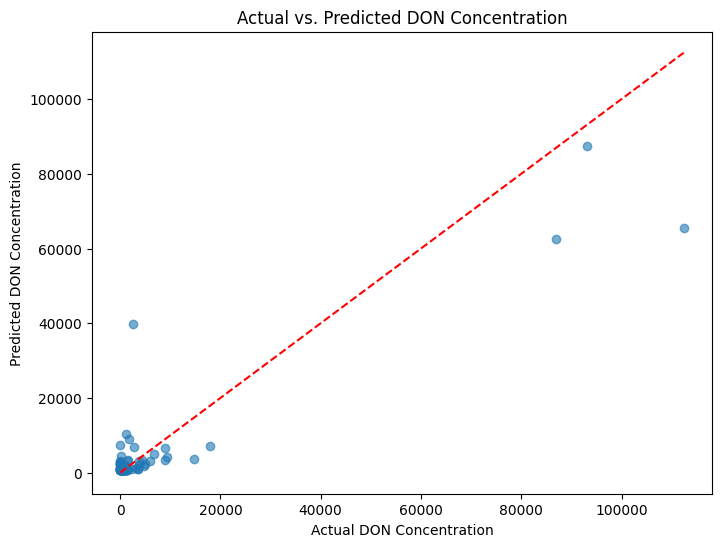

In [72]:
# Scatter Plot: Actual vs. Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_fnn, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual DON Concentration")
plt.ylabel("Predicted DON Concentration")
plt.title("Actual vs. Predicted DON Concentration")
plt.show()

# Interactive scatter plot using plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred_fnn.flatten(), mode='markers', marker=dict(size=8, color='blue', opacity=0.6)))
fig.add_trace(go.Scatter(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], mode='lines', line=dict(color='red', dash='dash')))
fig.update_layout(height=600, width=1000, title_text="FNN: Actual vs. Predicted DON Concentration", xaxis_title="Actual DON Concentration", yaxis_title="Predicted DON Concentration")
fig.write_html("visualizations-interactive/actual_vs_predicted_don_concentration (FNN).html")

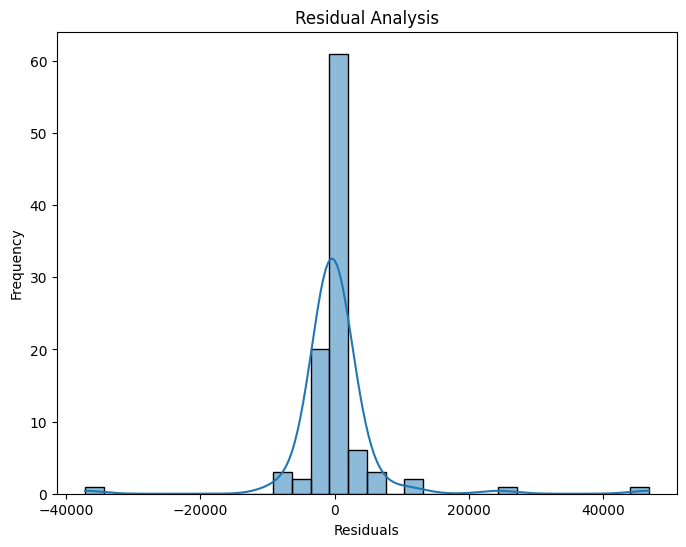

In [52]:
# Residual Analysis
residuals = y_test - y_pred_fnn.flatten()
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Analysis")
plt.show()

### - Interpretability

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<Figure size 1000x600 with 0 Axes>

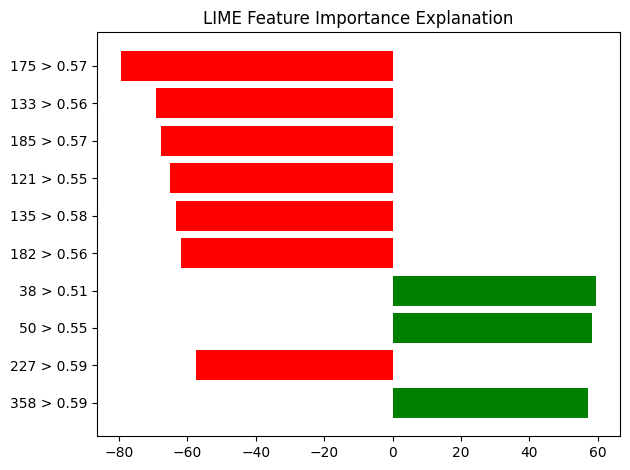

Top features contributing to the prediction:
175 > 0.57: -79.3127
133 > 0.56: -69.2265
185 > 0.57: -67.5795
121 > 0.55: -65.0963
135 > 0.58: -63.3971
182 > 0.56: -61.7851
38 > 0.51: 59.5144
50 > 0.55: 58.2336
227 > 0.59: -57.5084
358 > 0.59: 57.1755


In [53]:
# Model Interpretation using LIME
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=df.columns[:-1], mode='regression')
exp = explainer.explain_instance(X_test[0], fnn_best_model.predict)
# Visualize the LIME explanation using matplotlib instead of directly showing in notebook
fig = plt.figure(figsize=(10, 6))
exp.as_pyplot_figure(plt)
plt.tight_layout()
plt.title("LIME Feature Importance Explanation")
plt.show()

# Print the top features and their importance scores
print("Top features contributing to the prediction:")
for feature, importance in exp.as_list():
    print(f"{feature}: {importance:.4f}")

### Advanced Model - XGBoostRegressor

### - Metrics

In [54]:
y_pred_xgb = xgb_best_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGB: Final Mean Absolute Error (MAE): {mae_xgb:.4f}")
print(f"XGB: Final Root Mean Squared Error (RMSE): {rmse_xgb:.4f}")
print(f"XGB: Final R² Score: {r2_xgb:.4f}")

XGB: Final Mean Absolute Error (MAE): 4231.7473
XGB: Final Root Mean Squared Error (RMSE): 13368.4133
XGB: Final R² Score: 0.3607


### - Visual Evaluation

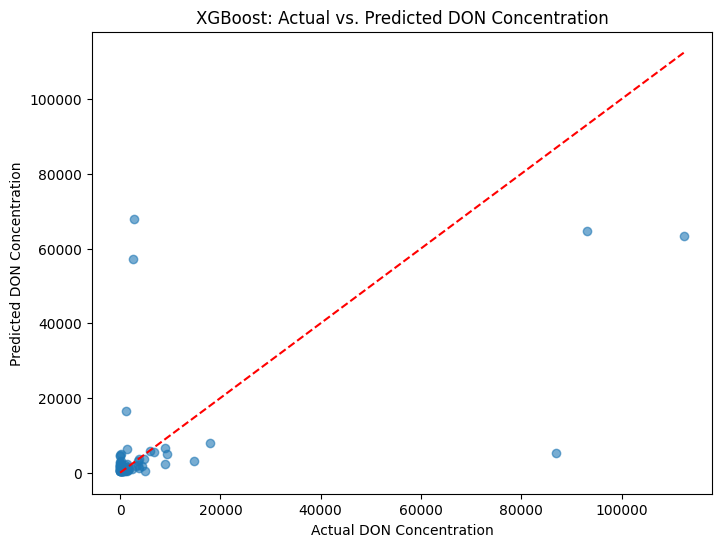

In [73]:
# Scatter Plot: Actual vs. Predicted values (XGBoost)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual DON Concentration")
plt.ylabel("Predicted DON Concentration")
plt.title("XGBoost: Actual vs. Predicted DON Concentration")
plt.show()

# Interactive scatter plot using plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred_xgb, mode='markers', marker=dict(size=8, color='green', opacity=0.6)))
fig.add_trace(go.Scatter(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], mode='lines', line=dict(color='red', dash='dash')))
fig.update_layout(height=600, width=1000, title_text="XGBoost: Actual vs. Predicted DON Concentration", xaxis_title="Actual DON Concentration", yaxis_title="Predicted DON Concentration")
fig.write_html("visualizations-interactive/actual_vs_predicted_don_concentration (XGBoost).html")

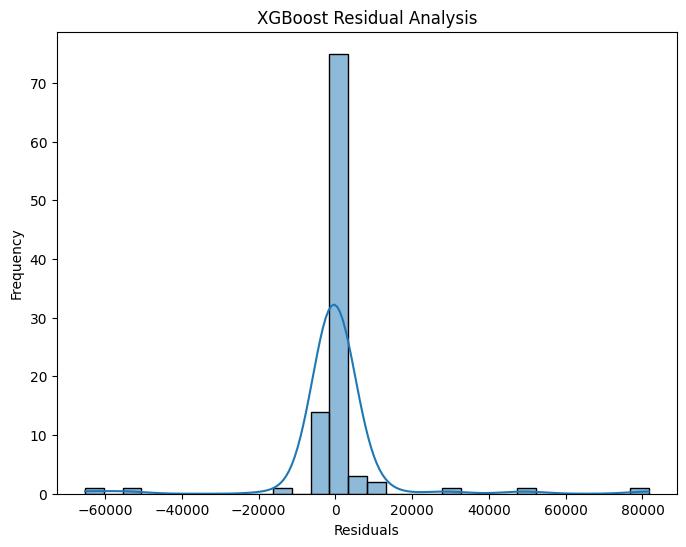

In [56]:
# Residual Analysis (XGBoost)
residuals_xgb = y_test - y_pred_xgb
plt.figure(figsize=(8, 6))
sns.histplot(residuals_xgb, kde=True, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("XGBoost Residual Analysis")
plt.show()

### - Interpretability

<Figure size 1000x600 with 0 Axes>

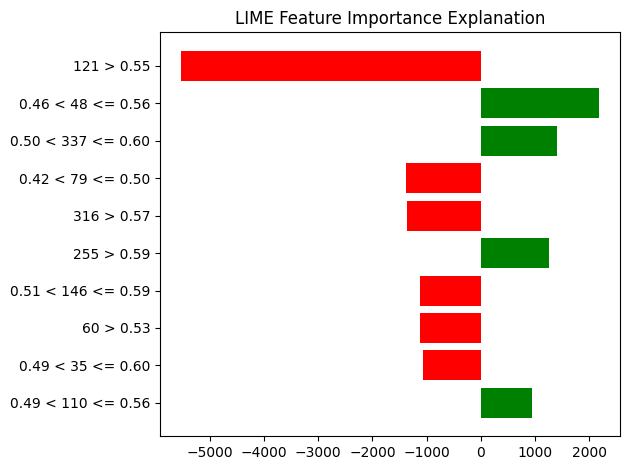

Top features contributing to the prediction:
121 > 0.55: -5526.2722
0.46 < 48 <= 0.56: 2178.4849
0.50 < 337 <= 0.60: 1396.1535
0.42 < 79 <= 0.50: -1375.5241
316 > 0.57: -1364.6941
255 > 0.59: 1263.6352
0.51 < 146 <= 0.59: -1123.9284
60 > 0.53: -1114.0951
0.49 < 35 <= 0.60: -1065.0309
0.49 < 110 <= 0.56: 943.8667


In [ ]:
# Model Interpretation using LIME (XGBoost)
xgb_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=df.columns[:-1], mode='regression')
xgb_exp = xgb_explainer.explain_instance(X_test[0], xgb_best_model.predict)

fig = plt.figure(figsize=(10, 6))
xgb_exp.as_pyplot_figure(plt)
plt.tight_layout()
plt.title("LIME Feature Importance Explanation")
plt.show()

# Print the top features and their importance scores
print("Top features contributing to the prediction:")
for feature, importance in xgb_exp.as_list():
    print(f"{feature}: {importance:.4f}")

<b>Saving the models and scaler for Deployment</b>

In [70]:
import joblib

fnn_best_model.save("models/fnn_model.h5")
joblib.dump(xgb_best_model, "models/xgb_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")

['models/scaler.pkl']

## Bonus - Ensemble Methods

In [58]:
# Averaging Predictions
avg_pred = (y_pred_xgb + y_pred_fnn) / 2
avg_pred

array([[ 773.26984, 1313.8505 , 2052.979  , ..., 1139.8811 ,  805.25903,
         855.7456 ],
       [2044.8059 , 2585.3865 , 3324.5151 , ..., 2411.4172 , 2076.7952 ,
        2127.2817 ],
       [ 794.2317 , 1334.8123 , 2073.941  , ..., 1160.843  ,  826.22095,
         876.70746],
       ...,
       [ 702.8866 , 1243.4672 , 1982.5957 , ..., 1069.4979 ,  734.8758 ,
         785.3623 ],
       [ 702.8866 , 1243.4672 , 1982.5957 , ..., 1069.4979 ,  734.8758 ,
         785.3623 ],
       [ 702.8866 , 1243.4672 , 1982.5957 , ..., 1069.4979 ,  734.8758 ,
         785.3623 ]], dtype=float32)

In [59]:
y_pred_xgb.shape

(100,)

In [60]:
y_pred_fnn.shape

(100, 1)

In [61]:
y_pred_nn_flatten = y_pred_fnn.flatten()
y_pred_nn_flatten.shape

(100,)

In [62]:
avg_pred_ens = (y_pred_xgb + y_pred_nn_flatten) / 2
avg_pred_ens

array([  773.26984,  2585.3865 ,  2073.941  ,   879.3235 ,  3361.8882 ,
        1087.0575 ,  2304.8174 ,  2294.1736 ,   678.0403 ,   957.77844,
         748.78534,   782.6105 ,  1143.7327 ,   910.4044 ,  1269.5917 ,
        4488.0615 ,   783.1832 ,  1367.8064 ,   702.664  ,   914.30554,
        1471.8103 ,  1159.4768 ,  1014.9225 ,  6102.4844 ,   669.36993,
        1549.4758 ,   598.7904 ,  1149.8246 ,  2416.71   ,   894.056  ,
         812.93677,  2227.8137 ,   742.03345,  1382.3562 ,   696.4386 ,
         956.3972 ,   640.72974,  3408.304  ,   611.9652 ,  1918.6283 ,
         947.94324,   773.7707 ,  3456.538  ,  1475.9473 ,   604.0153 ,
         680.88544,   997.2251 ,  2822.4407 ,  3436.0898 ,  1579.5269 ,
        2879.4316 ,  1272.2834 ,  7533.99   , 64444.543  ,   897.0705 ,
         887.042  ,  5076.094  ,  2661.0913 ,   576.4703 ,   934.6354 ,
        1032.5554 ,  1601.8555 , 37412.875  ,  4598.882  ,  1414.9833 ,
        1490.385  , 13418.809  ,  1264.3452 ,   571.0567 ,   818

In [77]:
import cloudpickle

class EnsembleModel:
    def __init__(self, xgb_model, fnn_model):
        self.xgb_model = xgb_model
        self.fnn_model = fnn_model

    def predict(self, X):
        y_pred_xgb = self.xgb_model.predict(X)
        y_pred_fnn = self.fnn_model.predict(X).flatten()
        return (y_pred_xgb + y_pred_fnn) / 2

# Create and save ensemble model
ensemble_model = EnsembleModel(xgb_best_model, fnn_best_model)
with open("models/ensemble_model.pkl", "wb") as f:
    cloudpickle.dump(ensemble_model, f)

In [64]:
mae_ensemble = mean_absolute_error(y_test, avg_pred_ens)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, avg_pred_ens))
r2_ensemble = r2_score(y_test, avg_pred_ens)
print(f"Ensemble MAE: {mae_ensemble:.4f}")
print(f"Ensemble RMSE: {rmse_ensemble:.4f}")
print(f"Ensemble R² Score: {r2_ensemble:.4f}")

Ensemble MAE: 3399.8202
Ensemble RMSE: 9666.2888
Ensemble R² Score: 0.6657


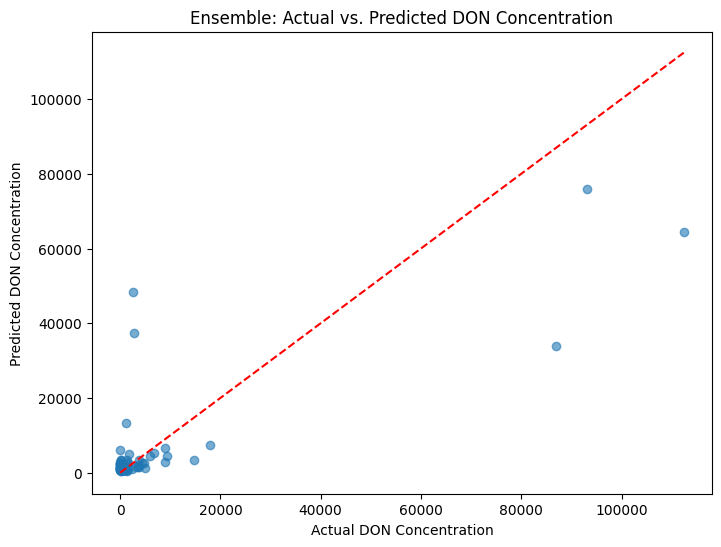

In [ ]:
# Scatter Plot: Actual vs. Predicted values (Ensemble)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, avg_pred_ens, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual DON Concentration")
plt.ylabel("Predicted DON Concentration")
plt.title("Ensemble: Actual vs. Predicted DON Concentration")
plt.show()

# Interactive scatter plot using plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=avg_pred_ens, mode='markers', marker=dict(size=8, color='lightcoral', opacity=0.6)))
fig.add_trace(go.Scatter(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], mode='lines', line=dict(color='red', dash='dash')))
fig.update_layout(height=600, width=1000, title_text="Ensemble: Actual vs. Predicted DON Concentration", xaxis_title="Actual DON Concentration", yaxis_title="Predicted DON Concentration")
fig.write_html("visualizations-interactive/actual_vs_predicted_don_concentration (Ensemble).html")

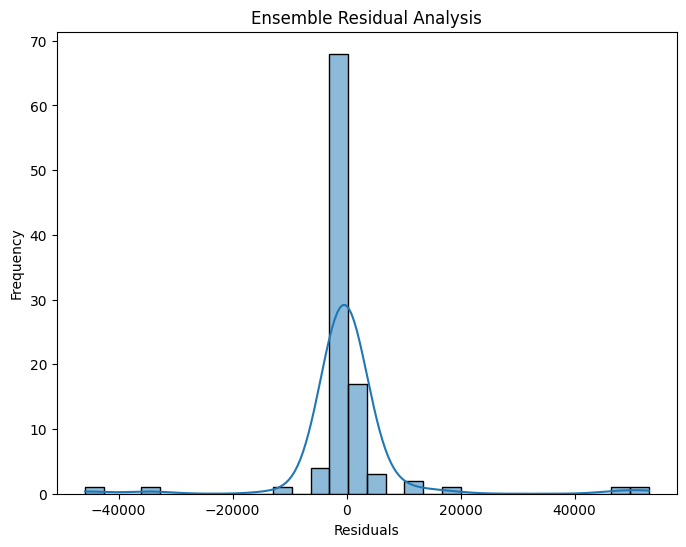

In [ ]:
# Residual Analysis (Ensemble)
residuals_ens = y_test - avg_pred_ens
plt.figure(figsize=(8, 6))
sns.histplot(residuals_ens, kde=True, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Ensemble Residual Analysis")
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


<Figure size 1000x600 with 0 Axes>

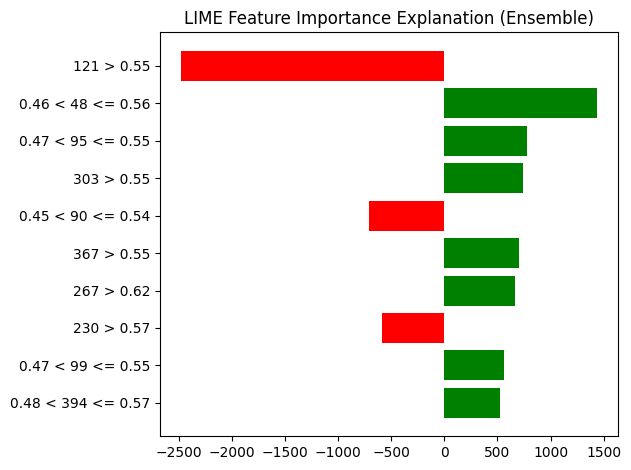

Top features contributing to the prediction (Ensemble):
121 > 0.55: -2480.6962
0.46 < 48 <= 0.56: 1439.8481
0.47 < 95 <= 0.55: 783.2256
303 > 0.55: 743.6101
0.45 < 90 <= 0.54: -712.0346
367 > 0.55: 701.9482
267 > 0.62: 664.5020
230 > 0.57: -590.1474
0.47 < 99 <= 0.55: 562.2818
0.48 < 394 <= 0.57: 526.9589


In [67]:
# Model Interpretation using LIME (Ensemble)
ensemble_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=df.columns[:-1], mode='regression')
ensemble_exp = ensemble_explainer.explain_instance(X_test[0], lambda x: (xgb_best_model.predict(x) + fnn_best_model.predict(x).flatten()) / 2)

fig = plt.figure(figsize=(10, 6))
ensemble_exp.as_pyplot_figure(plt)
plt.tight_layout()
plt.title("LIME Feature Importance Explanation (Ensemble)")
plt.show()

# Print the top features and their importance scores
print("Top features contributing to the prediction (Ensemble):")
for feature, importance in ensemble_exp.as_list():
    print(f"{feature}: {importance:.4f}")